In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import sys
import logging

In [82]:
useful_sensor = [1, 2, 3, 4, 11, 26, 17, 9, 10]
min_samples = 100

In [83]:
def count_fequency(df):
    # only select the useful information
    df = df[df.SENSORTYPE.isin(useful_sensor)]
    min_time = df.TIMESTAMP.min()
    max_time = df.TIMESTAMP.max()
    c = Counter(df.SENSORTYPE)
    print ("Count per 1 second")
    for i in c.keys():
        c[i] = c[i] / (float(max_time - min_time) /1000.0)

    print(c)

In [84]:
def save_user_info_into_database(tag_df):
    if (os.path.exists('../../data/database') is not True):
        os.mkdir('../../data/database')
    files = os.listdir('../../data/database')

    cur_user_info = pd.DataFrame([tag_df.iloc[0].tolist()[2:]], columns=tag_df.columns[2:].values.tolist(), index=[0])
    cur_user_info['start_time'] = pd.Series([tag_df.TimeStamp.min()])
    cur_user_info['end_time'] = pd.Series([tag_df.TimeStamp.max() + pd.Timedelta('9 seconds')])
    if 'tester_info.csv' not in files:
        cur_user_info.to_csv("../../data/database/tester_info.csv")
        return int(0)
    else:
        all_tester_info = pd.DataFrame.from_csv('../../data/database/tester_info.csv')
        all_tester_info = all_tester_info.append(cur_user_info, ignore_index = True)
        all_tester_info.to_csv('../../data/database/tester_info.csv')
        return int(all_tester_info.index.max())

In [85]:
def save_sensor_data_into_database(sensor_df):
    cur_sensor_df = sensor_df[~sensor_df.TagName.isnull()]
    if (os.path.exists('../../data/database') is not True):
        os.mkdir('../../data/database')
    files = os.listdir('../../data/database')
    if 'sensor_data.csv' not in files:
        cur_sensor_df.to_csv('../../data/database/sensor_data.csv')
    else:
        all_sensor_df = pd.DataFrame.from_csv('../../data/database/sensor_data.csv')
        all_sensor_df = all_sensor_df.append(cur_sensor_df, ignore_index = True)
        all_sensor_df.to_csv('../../data/database/sensor_data.csv')
        
    print("saved")

In [86]:
def read_tag_data(dir):
    tag_data = pd.read_csv(dir, skipinitialspace= True)
    tag_data.TimeStamp = pd.DataFrame(index = pd.to_datetime(tag_data.TimeStamp, utc = 'True')).tz_localize('Asia/Singapore').index
    return tag_data

def read_sensor_data(dir):
    sensor_data = pd.read_csv(dir, skiprows=13, skipinitialspace= True, )
    count_fequency(sensor_data)
    sensor_data.TIMESTAMP = pd.DataFrame(index = pd.to_datetime(sensor_data.TIMESTAMP, unit='ms', utc = 'True')).tz_localize('utc').tz_convert('Asia/Singapore').index
    return sensor_data

In [87]:
def time_difference(sensor_data, tag_data):
    sensor_time_calibration = sensor_data[sensor_data.SENSORTYPE == -1]
    tag_time_calibration = tag_data[tag_data.TagName == 'TIME_CALIBRATION']
    if len(sensor_time_calibration) != len(tag_time_calibration):
        print('The number of times of time calibration on watch and phone is different!')
        return None
    if len(sensor_time_calibration) == 0:
        print("No time calibration!")
        return None
    return np.mean(tag_time_calibration.TimeStamp - sensor_time_calibration.TIMESTAMP)


In [96]:
def find_last_divide_sign(s):
    res = None
    for i in range(len(s)):
        if s[i] == '/':
            res = i
            
    return res

In [89]:
def move_to_processed_file_folder(directory):
    file_name = directory[find_last_divide_sign(directory)+1:]
    os.rename(directory, "../../data/raw_data/processed_raw_data/" + file_name)

In [8]:
def consecutive_repeated_tag(tags):
    previous_tag = "None"
    previous_index = -99
    res = []
    for i in range(len(tags)):
        if tags[i] in ['ACTION_FINISH', 'TIME_CALIBRATION', 'wear_start']:
            continue
        if (previous_tag == tags[i]):
            res.append(previous_index)
        previous_tag = tags[i]
        previous_index = i
    return res

In [99]:
def main(sensordata_dir, tagdata_dir):
# def main():
#     sensor_data = read_sensor_data('../../data/raw_data/SENSORDATA_20171219-174424.txt')
#     tag_data = read_tag_data('../../data/raw_data/Tags_20171219-174712.txt')
    sensor_data = read_sensor_data(sensordata_dir)
    tag_data = read_tag_data(tagdata_dir)
    user_groups = list(set(tag_data['Tester_Name'].values.tolist()))

    for user in user_groups:
        cur_user_tag_df = tag_data[tag_data['Tester_Name'] == user]
#         if (cur_user_tag_df.iloc[0]['TagName'] != 'wear_start'):
#             logging.error("Cannot find wear_start tag! User: " + str(user))
#             sys.exit()
#         if (len(cur_user_tag_df[cur_user_tag_df['TagName'] == 'wear_start']) > 1):
#             logging.error("There are more than 1 wear_start tags! User: " + str(user))
#             sys.exit()

        cur_user_id = save_user_info_into_database(cur_user_tag_df)

        time_different_between_wear_phone = time_difference(sensor_data, tag_data)
        if time_different_between_wear_phone is None:
            return
        
        sensor_data.TIMESTAMP = sensor_data.TIMESTAMP + time_different_between_wear_phone

        tags = cur_user_tag_df.TagName.tolist()
        skip_tag_idx = consecutive_repeated_tag(tags)
        
        for i in range(len(tags)): 
            if i in skip_tag_idx:
                continue
            cur_tag = tags[i]
            if cur_tag in ['ACTION_FINISH', 'TIME_CALIBRATION', 'wear_start', 'wear_stop']:
                continue 
            cur_tag_start_time = (cur_user_tag_df.iloc[i].TimeStamp + pd.Timedelta('3 seconds'))
            if ((i + 1 < len(tags)) and (tags[i + 1] == 'ACTION_FINISH')):
                cur_tag_end_time = (cur_user_tag_df.iloc[i+1].TimeStamp)
                if (cur_tag_end_time - cur_tag_start_time > pd.Timedelta('5 seconds')):
                    cur_tag_end_time = (cur_tag_start_time + pd.Timedelta('5 seconds'))
            else:
                cur_tag_end_time = (cur_tag_start_time + pd.Timedelta('5 seconds'))
            if (len(sensor_data.loc[(sensor_data.TIMESTAMP < cur_tag_end_time) & (sensor_data.TIMESTAMP > cur_tag_start_time)]) < min_samples):
                print("Something wrong with tag " + cur_tag + " for user " + str(user) + " id " + str(cur_user_id))
                print("Number of samples is %d Less than threshold %d" % (len(sensor_data.loc[(sensor_data.TIMESTAMP < cur_tag_end_time) & (sensor_data.TIMESTAMP > cur_tag_start_time)]), min_samples))
                
                return
            sensor_data.loc[(sensor_data.TIMESTAMP < cur_tag_end_time) & (sensor_data.TIMESTAMP > cur_tag_start_time), 'TagName'] = cur_tag
            sensor_data.loc[(sensor_data.TIMESTAMP < cur_tag_end_time) & (sensor_data.TIMESTAMP > cur_tag_start_time), 'tester_id'] = cur_user_id

    save_sensor_data_into_database(sensor_data)
    
    move_to_processed_file_folder(sensordata_dir)
    move_to_processed_file_folder(tagdata_dir)


In [101]:
main('../../data/raw_data/SENSORDATA_20171219-173432.txt', "../../data/raw_data/Tags_20171219-173737.txt")
main('../../data/raw_data/SENSORDATA_20171219-174127.txt', "../../data/raw_data/Tags_20171219-174413.txt")
main('../../data/raw_data/SENSORDATA_20171221-181909.txt', "../../data/raw_data/Tags_20171221-181857.txt")
main('../../data/raw_data/SENSORDATA_20171221-182254.txt', "../../data/raw_data/Tags_20171221-182143.txt")

Count per 1 second
Counter({11: 189.91066005264224, 3: 189.91066005264224, 4: 189.56899169872443, 1: 183.07729297428628, 2: 98.53968414658837, 26: 0.03796315043531079})
saved
Count per 1 second
Counter({11: 193.713928610815, 3: 193.713928610815, 4: 193.49336470242255, 1: 186.43531963386394, 2: 98.66558835422565, 26: 0.02940852111899423})
saved
Count per 1 second
Counter({11: 194.21302946152127, 3: 194.21302946152127, 4: 193.933735516614, 1: 186.5045165820805, 2: 98.73439943822018, 26: 0.07181844297615628})
saved
Count per 1 second
Counter({11: 189.65759739955305, 3: 189.65759739955305, 4: 189.391926737408, 1: 182.51574489365362, 2: 98.61069871384144, 26: 0.09376611605119631})
saved


In [72]:
sensor_data = read_sensor_data('../../data/raw_data/processed_raw_data/SENSORDATA_20171221-181909.txt')


Counter({11: 194.21302946152127, 3: 194.21302946152127, 4: 193.933735516614, 1: 186.5045165820805, 2: 98.73439943822018, 26: 0.07181844297615628})


In [73]:
skip_tag_idx

[]

In [74]:
acc = sensor_data[sensor_data.SENSORTYPE == 1]
b = tag_data.loc[4,'TimeStamp']
e = tag_data.loc[5,'TimeStamp']

In [75]:
acc_action1 = acc[(acc.TIMESTAMP > b) & (acc.TIMESTAMP < e)]

In [76]:
import matplotlib.pyplot as plt


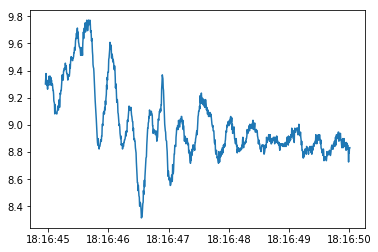

In [79]:
plt.plot(acc_action1.TIMESTAMP, acc_action1.VALUES3)
plt.show()